In [1]:
import pandas as pd
from preprocess import Audio_Processor
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import pylab as pl
from sklearn.preprocessing import normalize

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 85ms/step - loss: 1.2459
Epoch 1/1
2/2 [==============================] - 0s 47ms/step - loss: 1.3308
	Bytes: 4211344
	Processing Time: 33.43004512786865


In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,...,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000
mean,48.430784,50.418929,35.734120,31.474226,28.507680,26.971181,25.125723,25.069451,23.399979,23.032275,...,-0.010097,0.009135,-0.008238,0.006505,-0.007245,0.004310,-0.004971,0.003052,0.623402,24.497135
std,25.369643,28.666028,16.331744,13.891217,12.231724,11.416638,10.456013,10.425420,9.544580,9.385765,...,0.030425,0.029254,0.027525,0.027105,0.025615,0.025173,0.024499,0.023142,0.484586,14.519294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.156495,-0.139783,-0.155228,-0.126032,-0.139114,-0.121857,-0.126223,-0.122716,0.000000,0.000000
25%,29.474898,27.023068,23.575613,21.494624,20.154840,19.262486,18.013971,18.408166,17.044587,16.872658,...,-0.025173,-0.007681,-0.022001,-0.009076,-0.020681,-0.010344,-0.018532,-0.010127,0.000000,12.000000
50%,46.511030,47.030497,36.043425,31.848399,29.220590,27.193243,25.594728,25.610608,23.754334,23.560967,...,-0.005667,0.004993,-0.004546,0.003025,-0.004265,0.001313,-0.002949,0.000857,1.000000,24.000000
75%,64.705746,71.098213,46.809207,40.794668,36.352064,34.705359,32.375933,32.125075,30.069079,29.619586,...,0.006257,0.024001,0.006862,0.019628,0.007518,0.017877,0.008707,0.015849,1.000000,37.000000
max,162.944580,148.114151,93.262978,89.367409,91.938995,68.260246,67.058037,67.830833,60.431767,62.603237,...,0.140499,0.153488,0.142751,0.147354,0.146182,0.147818,0.146564,0.131608,1.000000,49.000000


In [12]:
X = df.drop(['l_target', 'h_target'], axis=1)
y_h = df['h_target']
y_l = df['l_target']

In [13]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,58.825085,40.770454,39.077618,33.502728,27.317091,25.635506,22.136000,19.259167,17.778555,18.393156,...,-0.010462,0.078901,-0.040294,-0.027048,-0.032280,0.007869,0.022984,-0.001057,0.003152,-0.006131
1,23.647884,17.039274,16.257879,14.457110,12.016403,11.585896,11.918257,10.937835,10.425471,9.869852,...,0.012515,-0.005377,-0.005691,0.007644,0.020794,0.019378,0.007404,-0.003032,-0.009512,-0.002601
2,9.183050,8.656765,6.198092,5.570678,4.207383,3.873962,4.513668,5.669260,6.126761,6.836194,...,-0.018180,0.009448,-0.031034,0.043490,-0.026430,0.010089,-0.026310,0.010708,-0.013805,0.011556
3,46.043644,50.801384,39.731125,32.719776,28.217848,25.872047,27.144468,32.759018,27.400797,29.561314,...,0.050531,0.015893,0.038365,0.019737,-0.011469,0.027355,-0.037758,0.003208,-0.002331,-0.021403
4,46.481998,89.581245,60.060421,38.625305,27.470835,35.489647,23.991663,25.052250,15.739599,25.204237,...,0.049583,0.038827,0.028088,-0.028416,0.048776,-0.003388,-0.020495,0.028141,-0.028267,-0.022968


In [14]:
X_norm = pd.DataFrame(normalize(X, axis=0))
X_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.015972,0.010435,0.014765,0.014456,0.013072,0.012994,0.012075,0.010530,0.010443,0.010978,...,-0.004302,0.034397,-0.018661,-0.013103,-0.016679,0.004191,0.012818,-0.000615,0.001872,-0.003900
1,0.006421,0.004361,0.006143,0.006238,0.005750,0.005872,0.006501,0.005980,0.006124,0.005891,...,0.005146,-0.002344,-0.002635,0.003703,0.010745,0.010321,0.004129,-0.001763,-0.005649,-0.001654
2,0.002493,0.002216,0.002342,0.002404,0.002013,0.001964,0.002462,0.003100,0.003599,0.004080,...,-0.007475,0.004119,-0.014372,0.021067,-0.013657,0.005374,-0.014673,0.006225,-0.008198,0.007350
3,0.012502,0.013003,0.015012,0.014118,0.013503,0.013113,0.014807,0.017911,0.016095,0.017644,...,0.020778,0.006929,0.017767,0.009561,-0.005926,0.014569,-0.021057,0.001865,-0.001385,-0.013613
4,0.012621,0.022929,0.022693,0.016667,0.013146,0.017988,0.013087,0.013697,0.009246,0.015044,...,0.020388,0.016927,0.013008,-0.013765,0.025203,-0.001805,-0.011430,0.016359,-0.016787,-0.014608


# PCA

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_norm)

In [16]:
pca_2d = pca.transform(X_norm)

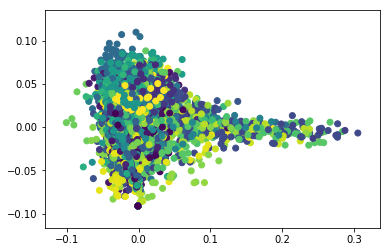

In [17]:
pl.figure('reference plot')
pl.scatter(pca_2d[:,0], pca_2d[:,1], c=y_h)

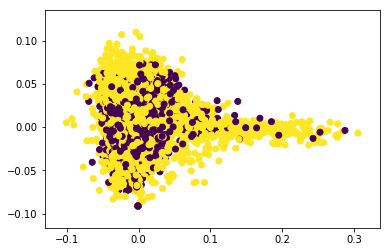

In [18]:
pl.figure('reference plot')
pl.scatter(pca_2d[:,0], pca_2d[:,1], c=y_l)

# ICA

In [19]:
from sklearn.decomposition import FastICA as ICA
ica = ICA(n_components=2).fit(X_norm)

In [20]:
ica_2d = ica.transform(X_norm)

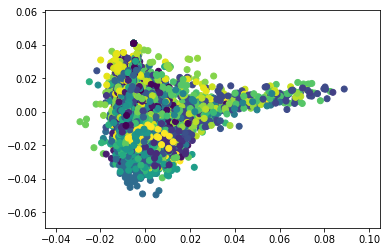

In [21]:
pl.figure('reference plot')
pl.scatter(ica_2d[:,0], ica_2d[:,1], c=y_h)

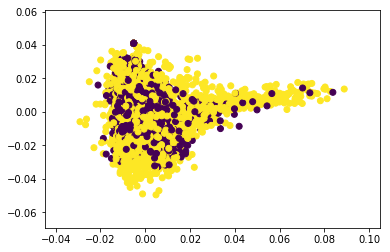

In [22]:
pl.figure('reference plot')
pl.scatter(ica_2d[:,0], ica_2d[:,1], c=y_l)

# SVD

In [23]:
from sklearn.decomposition import TruncatedSVD as SVD
svd = SVD(n_components=2).fit(X_norm)

In [24]:
svd_2d = svd.transform(X_norm)

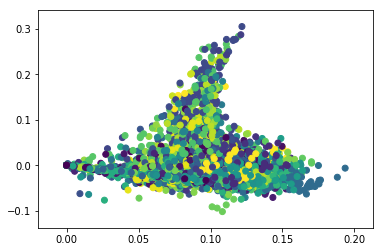

In [25]:
pl.figure('reference plot')
pl.scatter(svd_2d[:,0], svd_2d[:,1], c=y_h)

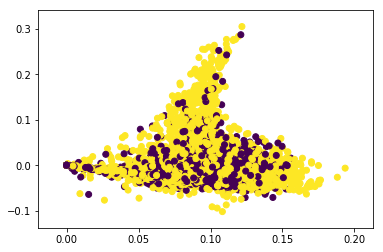

In [26]:
pl.figure('reference plot')
pl.scatter(svd_2d[:,0], svd_2d[:,1], c=y_l)

# LDA

In [27]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.preprocessing import minmax_scale
X_scale = pd.DataFrame(minmax_scale(X_norm))
X_scale.head()

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.361013,0.275264,0.419005,0.374888,0.297122,0.375555,0.330102,0.283929,0.294192,0.293805,...,0.487201,0.704457,0.391257,0.384405,0.412607,0.489789,0.568173,0.447946,0.474273,0.458409
1,0.145128,0.115042,0.174323,0.161772,0.130700,0.169731,0.177730,0.161252,0.172516,0.157657,...,0.562178,0.399217,0.507768,0.502698,0.590720,0.531884,0.513562,0.440623,0.427847,0.472291
2,0.056357,0.058447,0.066458,0.062335,0.045763,0.056753,0.067310,0.083579,0.101383,0.109199,...,0.462018,0.452909,0.422436,0.624925,0.432238,0.497908,0.395391,0.491574,0.412110,0.527957
3,0.282572,0.342988,0.426012,0.366126,0.306919,0.379021,0.404791,0.482952,0.453417,0.472201,...,0.686226,0.476252,0.656105,0.543932,0.482448,0.561062,0.355266,0.463761,0.454170,0.398360
4,0.285263,0.604812,0.643990,0.432208,0.298794,0.519917,0.357775,0.369334,0.260452,0.402603,...,0.683133,0.559315,0.621503,0.379741,0.684626,0.448610,0.415775,0.556218,0.359093,0.392208


In [28]:
lda = LDA(n_components=2).fit(X_scale)

In [29]:
lda_2d = lda.transform(X_scale)

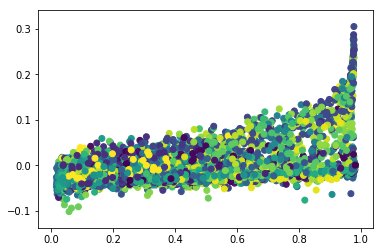

In [30]:
pl.figure('reference plot')
pl.scatter(lda_2d[:,0], svd_2d[:,1], c=y_h)

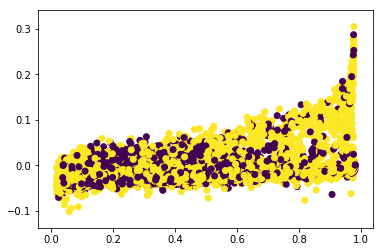

In [31]:
pl.figure('reference plot')
pl.scatter(lda_2d[:,0], svd_2d[:,1], c=y_l)